In [65]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import statsmodels.tools.tools as stattools
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix

Data Importing and Pre-processing

In [3]:
# Load the dataset 
data = pd.read_csv('data_science_salaries.csv')
data.head(10)

,job_title,experience_level,employment_type,work_models,work_year,employee_residence,salary,salary_currency,salary_in_usd,company_location,company_size
0,Data Engineer,Mid-level,Full-time,Remote,2024,United States,148100,USD,148100,United States,Medium
1,Data Engineer,Mid-level,Full-time,Remote,2024,United States,98700,USD,98700,United States,Medium
2,Data Scientist,Senior-level,Full-time,Remote,2024,United States,140032,USD,140032,United States,Medium
3,Data Scientist,Senior-level,Full-time,Remote,2024,United States,100022,USD,100022,United States,Medium
4,BI Developer,Mid-level,Full-time,On-site,2024,United States,120000,USD,120000,United States,Medium
5,BI Developer,Mid-level,Full-time,On-site,2024,United States,62100,USD,62100,United States,Medium
6,Research Analyst,Entry-level,Full-time,On-site,2024,United States,250000,USD,250000,United States,Medium
7,Research Analyst,Entry-level,Full-time,On-site,2024,United States,150000,USD,150000,United States,Medium
8,Data Engineer,Executive-level,Full-time,Remote,2024,United States,219650,USD,219650,United States,Medium
9,Data Engineer,Executive-level,Full-time,Remote,2024,United States,136000,USD,136000,United States,Medium


In [4]:
# Step 1: Find missing data
data.isnull().sum()

job_title             0
experience_level      0
employment_type       0
work_models           0
work_year             0
employee_residence    0
salary                0
salary_currency       0
salary_in_usd         0
company_location      0
company_size          0
dtype: int64

In [5]:
# Step 2: Check for duplicates and remove if any
data.duplicated().sum()

0

In [6]:
data.dtypes

job_title             object
experience_level      object
employment_type       object
work_models           object
work_year              int64
employee_residence    object
salary                 int64
salary_currency       object
salary_in_usd          int64
company_location      object
company_size          object
dtype: object

In [7]:
# Step 3: Encode categorical variables
categorical_cols = ['job_title', 'experience_level', 'employment_type', 
                    'work_models', 'employee_residence', 
                    'salary_currency', 'company_location', 'company_size']

# Dataset of only United States data
data = data[data['employee_residence'].str.contains('United States')]

# Step 4: Check for outliers in salary_in_usd using the IQR method
q1, q3 = data['salary_in_usd'].quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Remove rows with outliers in salary_in_usd
data_cleaned = data[(data['salary_in_usd'] >= lower_bound) & 
                            (data['salary_in_usd'] <= upper_bound)]

In [8]:
# Display summary of cleaned data
print(data_cleaned.info())
print(data_cleaned.head())

<class 'pandas.core.frame.DataFrame'>
Index: 5204 entries, 0 to 6556
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   job_title           5204 non-null   object
 1   experience_level    5204 non-null   object
 2   employment_type     5204 non-null   object
 3   work_models         5204 non-null   object
 4   work_year           5204 non-null   int64 
 5   employee_residence  5204 non-null   object
 6   salary              5204 non-null   int64 
 7   salary_currency     5204 non-null   object
 8   salary_in_usd       5204 non-null   int64 
 9   company_location    5204 non-null   object
 10  company_size        5204 non-null   object
dtypes: int64(3), object(8)
memory usage: 487.9+ KB
None
        job_title experience_level employment_type work_models  work_year  \
0   Data Engineer        Mid-level       Full-time      Remote       2024   
1   Data Engineer        Mid-level       Full-time      Remote 

In [9]:
data_cleaned['experience_level'].unique()

array(['Mid-level', 'Senior-level', 'Entry-level', 'Executive-level'],
      dtype=object)

In [10]:
data_cleaned.describe()

,work_year,salary,salary_in_usd
count,5204.000000,5204.000000,5204.000000
mean,2022.888163,153211.435050,153220.955419
std,0.590284,57568.049715,57552.569690
min,2020.000000,24000.000000,24000.000000
25%,2023.000000,110000.000000,110000.000000
50%,2023.000000,147000.000000,147000.000000
75%,2023.000000,190000.000000,190000.000000
max,2024.000000,318300.000000,318300.000000


Data Analysis and Visualization

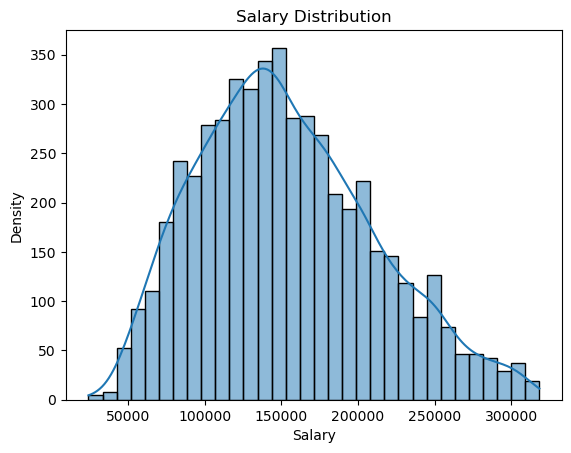

In [11]:
sns.histplot(data_cleaned['salary_in_usd'], kde=True)
plt.xlabel('Salary')
plt.ylabel('Density')
plt.title('Salary Distribution')
plt.show()

In [12]:
# Bin salary_in_usd into 4 categories
num_bins = 4
labels = ['Low', 'Medium', 'High', 'Very High']
data_cleaned['salary_binned'] = pd.qcut(data_cleaned['salary_in_usd'], q=num_bins, labels=labels)

/var/folders/6j/qtnqw_nn0bj948l89lgcc38m0000gn/T/ipykernel_92133/52521721.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['salary_binned'] = pd.qcut(data_cleaned['salary_in_usd'], q=num_bins, labels=labels)


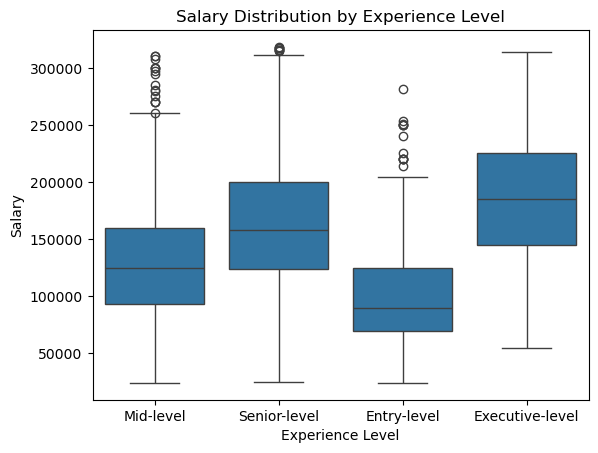

In [13]:
# Salary distribution across experience level
sns.boxplot(x='experience_level', y='salary_in_usd', data=data_cleaned)
plt.xlabel('Experience Level')
plt.ylabel('Salary')
plt.title('Salary Distribution by Experience Level')
plt.show()

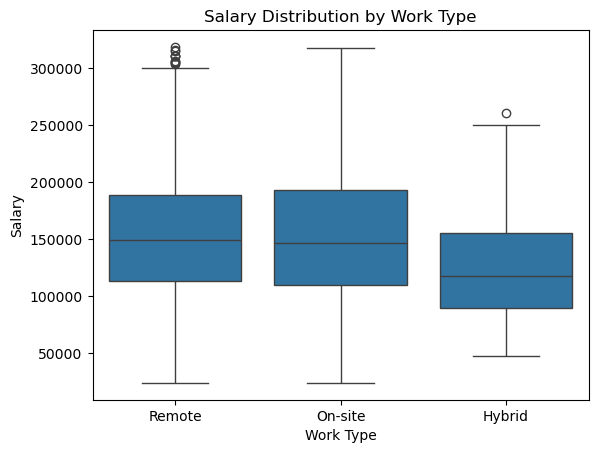

In [14]:
# Salary distribution across work type
sns.boxplot(x='work_models', y='salary_in_usd', data=data_cleaned)
plt.xlabel('Work Type')
plt.ylabel('Salary')
plt.title('Salary Distribution by Work Type')
plt.show()

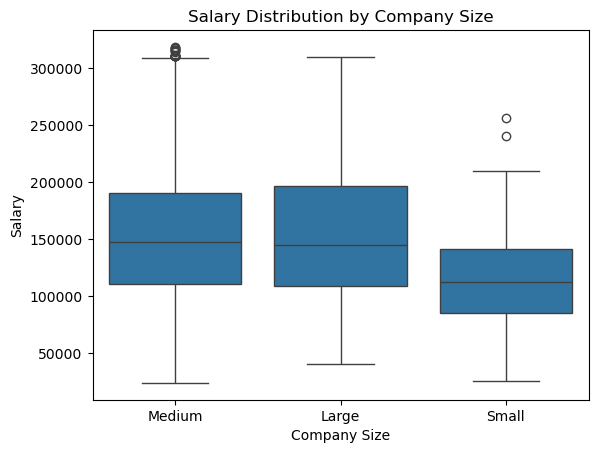

In [15]:
# Salary distribution across company size
sns.boxplot(x='company_size', y='salary_in_usd', data=data_cleaned)
plt.xlabel('Company Size')
plt.ylabel('Salary')
plt.title('Salary Distribution by Company Size')
plt.show()

In [16]:
interaction_effects = data_cleaned.groupby(['work_models', 'company_size'])['salary_in_usd'].mean().reset_index()

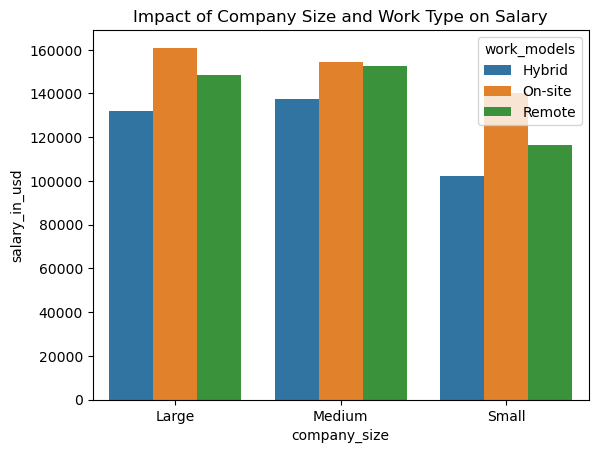

In [17]:
# Bar plot to visualize company size and work type on salary
sns.barplot(data=interaction_effects, x='company_size', y='salary_in_usd', hue='work_models')
plt.title("Impact of Company Size and Work Type on Salary")
plt.show()

In [18]:
interaction_effects2 = data_cleaned.groupby(['work_models', 'experience_level'])['salary_in_usd'].mean().reset_index()

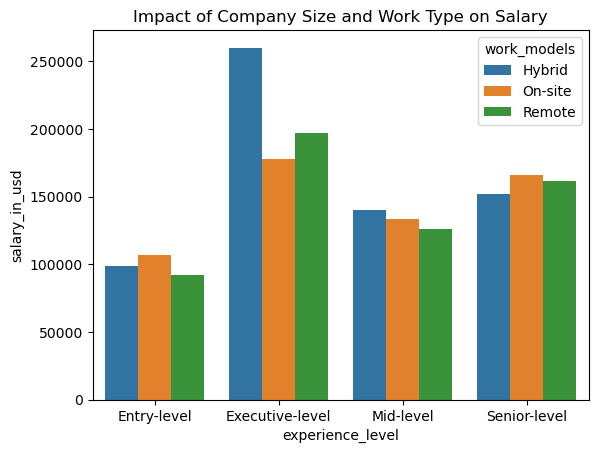

In [19]:
# Bar plot to visualize experience level and work type on salary
sns.barplot(data=interaction_effects2, x='experience_level', y='salary_in_usd', hue='work_models')
plt.title("Impact of Company Size and Work Type on Salary")
plt.show()

In [20]:
# Median of salary
salary_median = data_cleaned['salary_in_usd'].median()

In [21]:
# Convert 'salary_in_usd' to binary
data_cleaned['salary_binary'] = data_cleaned['salary_in_usd'].apply(lambda x: 'High' if x > salary_median else 'Low')

/var/folders/6j/qtnqw_nn0bj948l89lgcc38m0000gn/T/ipykernel_92133/884209481.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['salary_binary'] = data_cleaned['salary_in_usd'].apply(lambda x: 'High' if x > salary_median else 'Low')


<Axes: xlabel='company_size'>

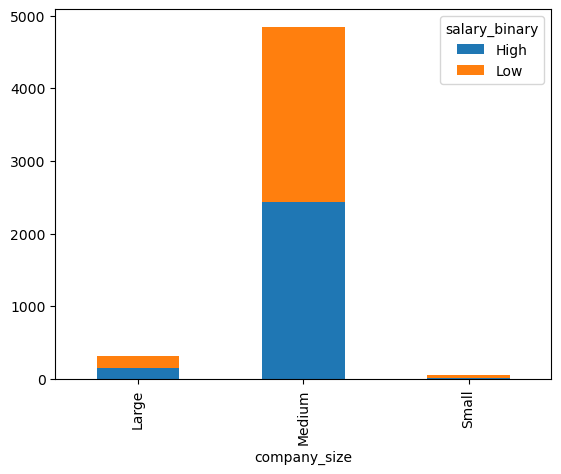

In [22]:
company_salary = pd.crosstab(data_cleaned['company_size'], data_cleaned['salary_binary'])
company_salary.plot(kind='bar', stacked=True)

<Axes: xlabel='company_size'>

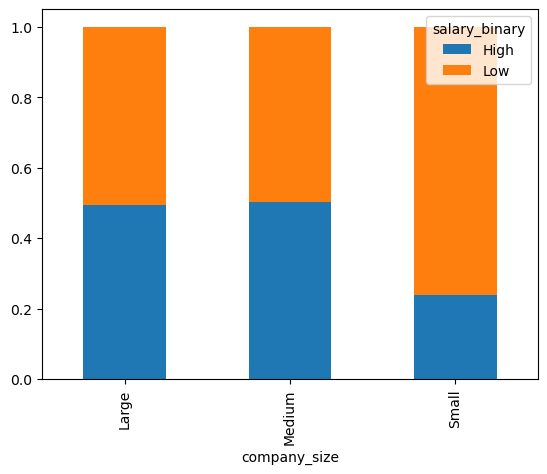

In [23]:
# Normalized
company_salary_norm = company_salary.div(company_salary.sum(1), axis = 0)
company_salary_norm.plot(kind='bar', stacked=True)

In [24]:
conting_table = pd.crosstab(data_cleaned['salary_binary'], data_cleaned['company_size'])
conting_table

company_size,Large,Medium,Small
salary_binary,,,
High,154,2431,12
Low,157,2412,38


<Axes: xlabel='experience_level'>

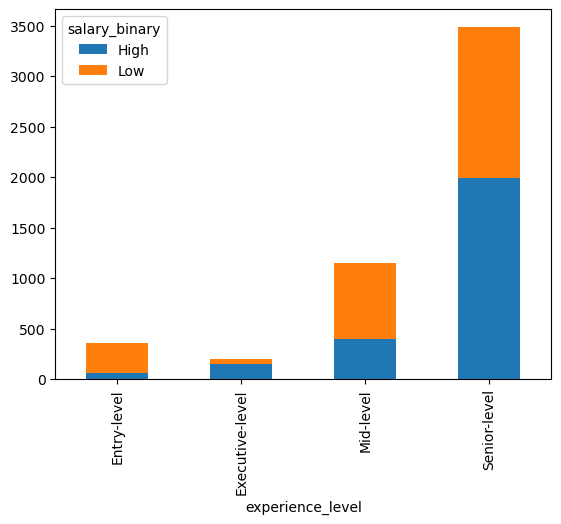

In [25]:
# Bar graph of experience_level by salary
experience_salary = pd.crosstab(data_cleaned['experience_level'], data_cleaned['salary_binary'])
experience_salary.plot(kind='bar', stacked=True)

<Axes: xlabel='experience_level'>

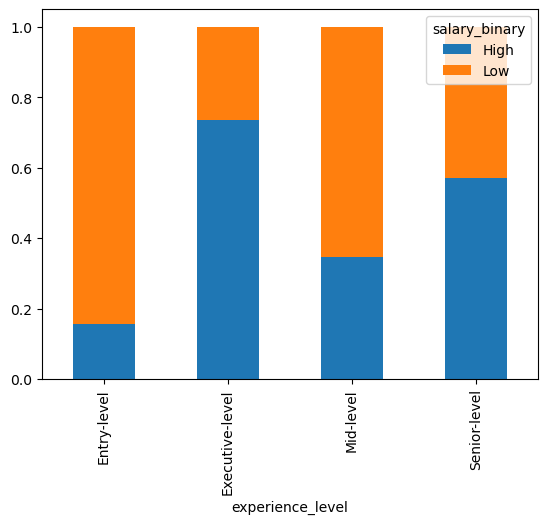

In [26]:
# Normalized
experience_salary_norm = experience_salary.div(experience_salary.sum(1), axis = 0)
experience_salary_norm.plot(kind='bar', stacked=True)

In [27]:
conting_table1 = pd.crosstab(data_cleaned['salary_binary'], data_cleaned['experience_level'])
conting_table1

experience_level,Entry-level,Executive-level,Mid-level,Senior-level
salary_binary,,,,
High,57,148,399,1993
Low,304,53,754,1496


Split dataset to training and test

In [28]:
# Partition dataset 
data_cleaned = data_cleaned.reset_index(drop=True)
data_train, data_test = train_test_split(data_cleaned, test_size = 0.2, random_state = 7)

In [29]:
# Confirm split proportions
split_proportions = pd.DataFrame({'Dataset': ['Training', 'Test'],
                                  'Proportion': [len(data_train) / len(data_cleaned), len(data_test) / len(data_cleaned)]
})

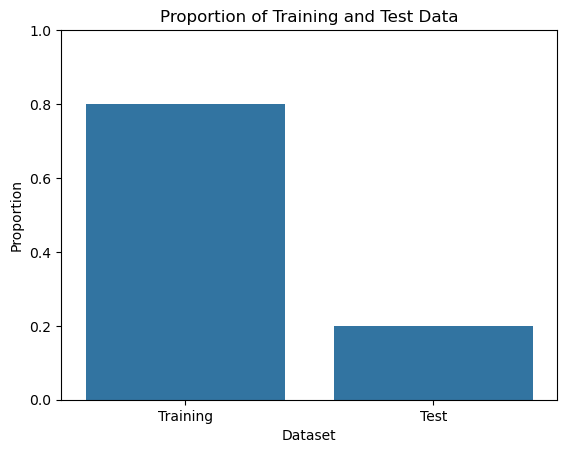

In [30]:
sns.barplot(x='Dataset', y='Proportion', data=split_proportions)

plt.title('Proportion of Training and Test Data')
plt.ylabel('Proportion')
plt.xlabel('Dataset')
plt.ylim(0, 1)
plt.show()

In [34]:
count = data_train['salary_binary'].value_counts()
count

salary_binary
High    2085
Low     2078
Name: count, dtype: int64

In [43]:
data_train['salary_binary'] = data_train['salary_binary'].astype(str)

In [44]:
prop_train = (data_train['salary_binary'] == 'High').mean()
prop_test = (data_test['salary_binary'] == 'High').mean()
n_train = len(data_train)
n_test = len(data_test)
prop_combined = ((data_train['salary_binary'] == 'High').sum() + (data_test['salary_binary'] == 'High').sum()) / (n_train + n_test)
se = np.sqrt(prop_combined * (1 - prop_combined) * (1 / n_train + 1 / n_test))

In [45]:
# Two-tailed Z-test
Z_test = (prop_train - prop_test) / se
p_value = 2 * (1 - norm.cdf(abs(Z_test)))

print(f"Z-statistic: {Z_test:.4f}")
print(f"P-value: {p_value:.4f}")

Z-statistic: 0.5198
P-value: 0.6032


In [55]:
# Preparing variables for modeling
salary_encoded = pd.get_dummies(data_train['salary_binary'])
company_encoded = pd.get_dummies(data_train['company_size'])
experience_encoded = pd.get_dummies(data_train['experience_level'])
work_encoded = pd.get_dummies(data_train['work_models'])

salary_encoded_test = pd.get_dummies(data_test['salary_binary'])
company_encoded_test = pd.get_dummies(data_test['company_size'])
experience_encoded_test = pd.get_dummies(data_test['experience_level'])
work_encoded_test = pd.get_dummies(data_test['work_models'])

In [56]:
salary_encoded = salary_encoded.astype(int)
company_encoded = company_encoded.astype(int)
experience_encoded = experience_encoded.astype(int)
work_encoded = work_encoded.astype(int)

salary_encoded_test = salary_encoded_test.astype(int)
company_encoded_test = company_encoded_test.astype(int)
experience_encoded_test = experience_encoded_test.astype(int)
work_encoded_test = work_encoded_test.astype(int)

In [57]:
company_pd = pd.DataFrame(company_encoded)
experience_pd = pd.DataFrame(experience_encoded)
work_pd = pd.DataFrame(work_encoded)

company_pd_test = pd.DataFrame(company_encoded_test)
experience_pd_test = pd.DataFrame(experience_encoded_test)
work_pd_test = pd.DataFrame(work_encoded_test)

X = pd.concat((company_pd, experience_pd, work_pd), axis = 1)
y = pd.DataFrame(salary_encoded)

X_test = pd.concat((company_pd_test, experience_pd_test, work_pd_test), axis = 1)
y_test = pd.DataFrame(salary_encoded_test)

In [58]:
X_names = ["Large", "Medium", "Small", "Entry-level", "Executive-level", "Mid-level", "Senior-level", "Hybrid", "On-site", "Remote"]
y_names = ["High", "Low"]

CART

In [59]:
cart = DecisionTreeClassifier(criterion = "gini", max_leaf_nodes=5).fit(X,y)

[Text(0.5555555555555556, 0.875, 'Senior-level <= 0.5\ngini = 0.5\nsamples = 4163\nvalue = [[2078, 2085]\n[2085, 2078]]'),
 Text(0.3333333333333333, 0.625, 'Executive-level <= 0.5\ngini = 0.457\nsamples = 1377\nvalue = [[891, 486]\n[486, 891]]'),
 Text(0.2222222222222222, 0.375, 'Entry-level <= 0.5\ngini = 0.421\nsamples = 1217\nvalue = [[850, 367]\n[367, 850]]'),
 Text(0.1111111111111111, 0.125, 'gini = 0.452\nsamples = 932\nvalue = [[611, 321]\n[321, 611]]'),
 Text(0.3333333333333333, 0.125, 'gini = 0.271\nsamples = 285\nvalue = [[239, 46]\n[46, 239]]'),
 Text(0.4444444444444444, 0.375, 'gini = 0.381\nsamples = 160\nvalue = [[41, 119]\n[119, 41]]'),
 Text(0.7777777777777778, 0.625, 'Small <= 0.5\ngini = 0.489\nsamples = 2786\nvalue = [[1187, 1599]\n[1599, 1187]]'),
 Text(0.6666666666666666, 0.375, 'gini = 0.489\nsamples = 2775\nvalue = [[1179, 1596]\n[1596, 1179]]'),
 Text(0.8888888888888888, 0.375, 'gini = 0.397\nsamples = 11\nvalue = [[8, 3]\n[3, 8]]')]

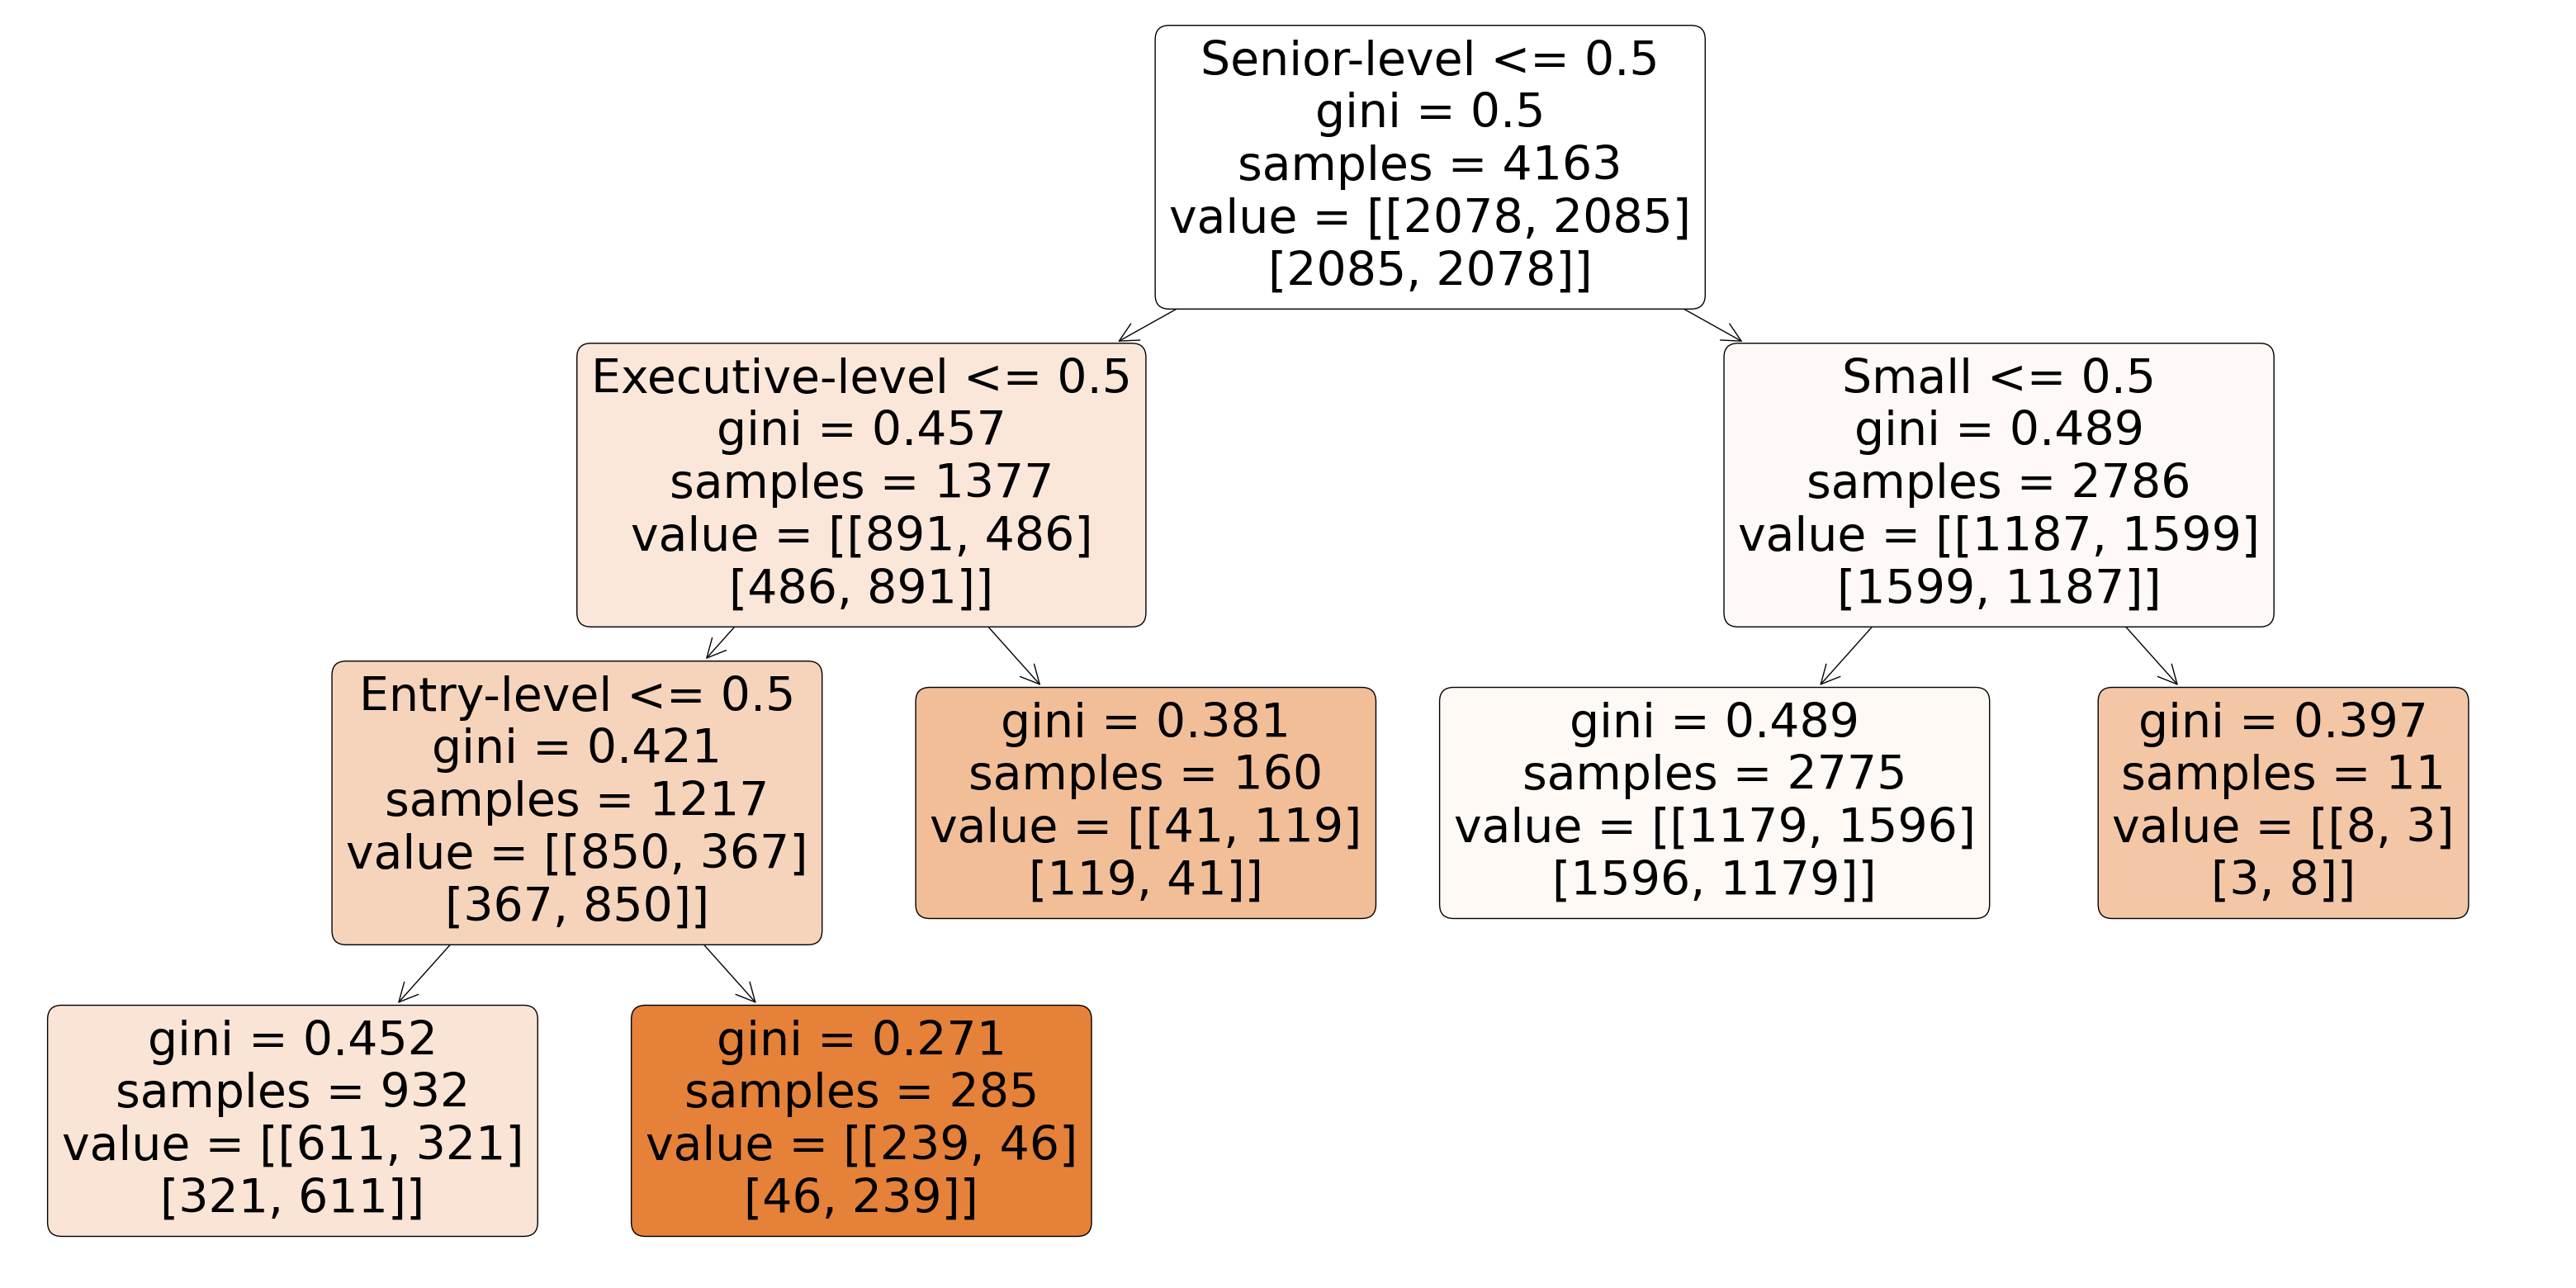

In [63]:
plt.figure(figsize=(40,20))
plot_tree(cart,
          feature_names = X_names,
          class_names = y_names,
          filled=True,
          rounded = True)

In [76]:
pred_CART = cart.predict(X_test)
pred_CART

array([[1, 0],
       [1, 0],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [77]:
table1 = confusion_matrix(data_test[['salary_binary']], pred_CART)
table1_df = pd.DataFrame(table1, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
table1_df['Total'] = table1_df.sum(axis=1)
table1_df.loc['Total'] = table1_df.sum(axis=0)
table1_df

ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

C5.0 Model

In [63]:
c50 = DecisionTreeClassifier(criterion="entropy", max_leaf_nodes=5).fit(X,y)

In [65]:
ypred = c50.predict(X_test)

ValueError: Input X contains NaN.
DecisionTreeClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Logistic Regression

Random Forest

Naive Bayes

Neural Network

ROC Curve